In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
u_cols = ["user_id", "age", "sex", "occupation", "zip_code"]
users = pd.read_csv("./data/ml-100k/u.user", sep="|", header=None, names=u_cols, encoding="latin-1")
print("Number of users:", users.shape[0])

#rates
r_cols = ["user_id", "item_id", "rating", "unix_timestamp"]
ratings_base = pd.read_csv("./data/ml-100k/ua.base", sep="\t", header=None, names=r_cols, encoding="latin-1")
ratings_test = pd.read_csv("./data/ml-100k/ua.test", sep="\t", header=None, names=r_cols, encoding="latin-1")
print("Number of ratings in base set:", ratings_base.shape[0])
print("Number of ratings in test set:", ratings_test.shape[0])

#items
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('./data/ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')
print("Number of items:", items.shape[0])

Number of users: 943
Number of ratings in base set: 90570
Number of ratings in test set: 9430
Number of items: 1682


In [3]:
user_mean_ratings = ratings_base.groupby('user_id')['rating'].mean()

- **Độ đo tương đồng phổ biến cho user-based CF: Pearson correlation**
  
  - $a, b$: users
  - $r_{a,p}$: rating của user $a$ cho item $p$
  - $P$: tập hợp các item được rate bởi cả $a$ và $b$
  
- Possible similarity values between -1 and 1

  $$
  \text{sim}(a, b) = \frac{\sum_{p \in P} (r_{a,p} - \bar{r}_a)(r_{b,p} - \bar{r}_b)}{\sqrt{\sum_{p \in P} (r_{a,p} - \bar{r}_a)^2} \sqrt{\sum_{p \in P} (r_{b,p} - \bar{r}_b)^2}}
  $$

In [4]:
def pearson_correlation(user1, user2):
    """
    Calculate Pearson correlation between ratings of two users
    
    Parameters:
    user1, user2: user IDs to compare
    
    Returns:
    float: Pearson correlation coefficient between the two users
    """
    # Get items rated by each user
    items_user1 = ratings_base[ratings_base["user_id"] == user1][["item_id", "rating"]]
    items_user2 = ratings_base[ratings_base["user_id"] == user2][["item_id", "rating"]]
    
    # Find common items
    common_items = pd.merge(items_user1, items_user2, on="item_id", suffixes=('_user1', '_user2'))

    # If less than 3 common items, return 0 (not enough data for reliable correlation)
    if len(common_items) < 3:
        return 0
    
    # Get mean ratings for each user
    mean_rating_user1 = items_user1["rating"].mean()
    mean_rating_user2 = items_user2["rating"].mean()
    
    # Calculate numerator and denominators for Pearson formula
    numerator = sum((common_items["rating_user1"] - mean_rating_user1) * 
                    (common_items["rating_user2"] - mean_rating_user2))
    
    denominator_user1 = sum((common_items["rating_user1"] - mean_rating_user1)**2)**0.5
    denominator_user2 = sum((common_items["rating_user2"] - mean_rating_user2)**2)**0.5
    
    # Check for division by zero
    if denominator_user1 == 0 or denominator_user2 == 0:
        return 0
    
    # Calculate and return correlation
    correlation = numerator / (denominator_user1 * denominator_user2)
    
    # Apply significance weighting (optional but recommended)
    # This gives more weight to correlations based on more common items
    if len(common_items) < 50:
        correlation = correlation * (len(common_items) / 50)
    
    return correlation

## Chỉ tính toán độ tương đồng khi được gọi đến

In [5]:
class LazySimilarityMatrix:
    def __init__(self):
        self.similarity_cache = {}
        
    def get_similarity(self, user1, user2):
        """Get similarity between two users with caching"""
        if user1 == user2:
            return 1.0
        
        # Use a consistent order for the key to avoid duplicates
        cache_key = tuple(sorted([user1, user2]))
        
        if cache_key not in self.similarity_cache:
            sim = pearson_correlation(user1, user2)
            self.similarity_cache[cache_key] = sim
            
        return self.similarity_cache[cache_key]
    
    def get_top_k_similar_users(self, user_id, k=20, exclude_negative=True):
        """Find k users most similar to the given user"""
        user_ids = ratings_base["user_id"].unique()
        similarities = []
        
        for other_user_id in user_ids:
            if other_user_id != user_id:
                sim = self.get_similarity(user_id, other_user_id)
                # Option to exclude users with negative correlation
                if not exclude_negative or sim > 0:
                    similarities.append((other_user_id, sim))
        
        # Sort by similarity (descending) and take top k
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:k]

In [6]:
similarity_matrix = LazySimilarityMatrix()

In [176]:
user_mean_ratings = ratings_base.groupby('user_id')['rating'].mean()

- **Hàm dự đoán:**
  
  $$
  \text{pred}(a, p) = \bar{r}_a + \frac{\sum_{b \in N} \text{sim}(a, b) * (r_{b,p} - \bar{r}_b)}{\sum_{b \in N} \text{sim}(a, b)}
  $$

- Tính toán độ lệch điểm mỗi láng giềng trên item $p$ so với điểm trung bình của họ.
- Kết hợp độ lệch điểm trung bình của các láng giềng với trọng số tương đồng của user $a$.
- Cộng với mức độ bias của user $a$.

In [ ]:
def predict_rating(user_id, item_id, k=20, rating_range=(1, 5)):
    """
    Predict rating for a given user-item pair using user-based collaborative filtering
    
    Parameters:
    user_id: ID of the user
    item_id: ID of the item
    k: Number of similar users to consider
    rating_range: Valid range for ratings (min, max)
    
    Returns:
    float: Predicted rating
    """
    # Check if the user has already rated this item
    is_rated = ratings_base[(ratings_base['user_id'] == user_id) & (ratings_base['item_id'] == item_id)]
    if not is_rated.empty:
        return is_rated['rating'].iloc[0]
    
    # Get k most similar users
    similar_users = similarity_matrix.get_top_k_similar_users(user_id, k)
    
    # Get mean rating for the current user
    if user_id in user_mean_ratings:
        mean_rating_user = user_mean_ratings[user_id]
    else:
        mean_rating_user = ratings_base['rating'].mean()  # Global mean as fallback
    
    # Get all ratings for this item from users in our similar users list
    similar_user_ids = [uid for uid, _ in similar_users]
    item_ratings = ratings_base[
        (ratings_base['item_id'] == item_id) & 
        (ratings_base['user_id'].isin(similar_user_ids))
    ]
    
    # Convert to dictionary for faster lookup
    similar_user_ratings = {row['user_id']: row['rating'] for _, row in item_ratings.iterrows()}
    
    numerator = 0
    denominator = 0
    
    for similar_user_id, similarity_score in similar_users:
        if similar_user_id in similar_user_ratings:
            # Get the rating this similar user gave to the item
            similar_user_rating = similar_user_ratings[similar_user_id]
            
            # Get the mean rating for this similar user
            similar_user_mean = user_mean_ratings.get(similar_user_id, 
                                               ratings_base['rating'].mean())
            
            # Use normalized rating in the calculation
            numerator += similarity_score * (similar_user_rating - similar_user_mean)
            denominator += abs(similarity_score)
    
    # If no similar users rated this item, return user's mean rating
    if denominator == 0:
        return mean_rating_user
    
    # Calculate predicted rating using weighted average of normalized ratings
    predicted_rating = mean_rating_user + (numerator / denominator)
    
    min_rating, max_rating = rating_range
    return max(min_rating, min(max_rating, predicted_rating))

## Evaluate model trên tập test, bản evaluate trên tập val và tập test ở file userKNN.py

In [14]:
from tqdm import tqdm
def evaluate_model(k=20, metric='rmse'):
    """
    Evaluate the recommender model on the test set
    
    Parameters:
    k: Number of similar users to consider
    metric: Evaluation metric ('rmse' or 'mae')
    
    Returns:
    float: Error metric value (lower is better)
    """
    errors = []
    total = len(ratings_test)
    print(f"Evaluating model with k={k} on {total} test samples...")
    
    # Optional: show progress for long evaluations
    progress_step = max(1, total // 10)
    
    with tqdm(total=total, desc="Evaluating", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:
        for _, row in ratings_test.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            predicted_rating = predict_rating(user_id, item_id, k)

            if metric == 'rmse':
                errors.append((predicted_rating - actual_rating) ** 2)
            else:  # mae
                errors.append(abs(predicted_rating - actual_rating))
            
            pbar.update(1)
            
    if metric == 'rmse':
        return np.sqrt(np.mean(errors))
    else:  # mae
        return np.mean(errors)

## Hàm validation để tìm ra siêu tham số K. Hàm chuẩn xác hơn sử dụng kĩ thuật k-folds cross-validation ở file userKNN.py

In [25]:
def find_optimal_k(k_values=None):
    """Find the optimal k value for the KNN algorithm"""
    if k_values is None:
        k_values = [5, 10, 20, 30, 40, 50]
    
    results = []
    
    for k in k_values:
        # Use a small sample for efficiency
        sample_size = len(ratings_test)
        sample = ratings_test.sample(sample_size)
        
        errors = []
        for _, row in sample.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            predicted_rating = predict_rating(user_id, item_id, k)
            errors.append((predicted_rating - actual_rating) ** 2)
        
        rmse = np.sqrt(np.mean(errors))
        results.append((k, rmse))
        print(f"k={k}, RMSE={rmse:.4f}")
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    
    k_list = [result[0] for result in results]
    rmse_list = [result[1] for result in results]
    
    plt.plot(k_list, rmse_list, marker='o')
    plt.xlabel('k (Number of neighbors)')
    plt.ylabel('RMSE')
    plt.title('RMSE vs. k')
    plt.grid(True)
    plt.savefig('User-KNN_optimization.png')
    plt.show()
    
    
    # Find k with lowest error
    optimal_k = min(results, key=lambda x: x[1])
    return optimal_k

In [10]:
def recommend_items(user_id, n=10, exclude_rated=True):
    """
    Recommend top N items for a given user
    
    Parameters:
    user_id: ID of the user
    n: Number of recommendations to make
    exclude_rated: Whether to exclude items the user has already rated
    
    Returns:
    list: Tuples of (item_id, predicted_rating)
    """
    # Get all items
    all_items = items['movie id'].unique()
    
    # Get items already rated by the user if we want to exclude them
    if exclude_rated:
        rated_items = ratings_base[ratings_base['user_id'] == user_id]['item_id'].unique()
        candidate_items = [item for item in all_items if item not in rated_items]
    else:
        candidate_items = all_items
    
    # Predict ratings for candidate items
    predictions = []
    for item_id in candidate_items:
        pred_rating = predict_rating(user_id, item_id)
        predictions.append((item_id, pred_rating))
    
    # Sort by predicted rating (descending) and take top n
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

In [11]:
pred = predict_rating(2, 281)
print(f"Predicted rating for user 2, item 281: {pred:.2f}")

Predicted rating for user 2, item 281: 3.08


In [15]:
error = evaluate_model(k=20, metric='rmse')
print(f"RMSE with k=20: {error:.4f}")

Evaluating model with k=20 on 9430 test samples...


Evaluating: 100%|███████████████████████████████████████████████| 9430/9430 [12:49<00:00, 12.25it/s]

RMSE with k=20: 1.0072


k=5, RMSE=1.0771
k=10, RMSE=1.0397
k=15, RMSE=1.0172
k=20, RMSE=1.0072
k=25, RMSE=0.9970
k=30, RMSE=0.9906
k=35, RMSE=0.9862
k=40, RMSE=0.9819
k=45, RMSE=0.9796
k=50, RMSE=0.9770
k=55, RMSE=0.9751
k=60, RMSE=0.9719
k=65, RMSE=0.9714
k=70, RMSE=0.9708
k=75, RMSE=0.9682
k=80, RMSE=0.9666
k=85, RMSE=0.9655
k=90, RMSE=0.9641
k=95, RMSE=0.9633
k=100, RMSE=0.9629
k=105, RMSE=0.9625
k=110, RMSE=0.9627
k=115, RMSE=0.9625
k=120, RMSE=0.9622
k=125, RMSE=0.9625
k=130, RMSE=0.9619
k=135, RMSE=0.9623
k=140, RMSE=0.9618
k=145, RMSE=0.9616
k=150, RMSE=0.9615
k=155, RMSE=0.9615
k=160, RMSE=0.9611
k=165, RMSE=0.9609
k=170, RMSE=0.9610
k=175, RMSE=0.9607
k=180, RMSE=0.9607
k=185, RMSE=0.9609
k=190, RMSE=0.9609
k=105, RMSE=0.9625
k=200, RMSE=0.9615


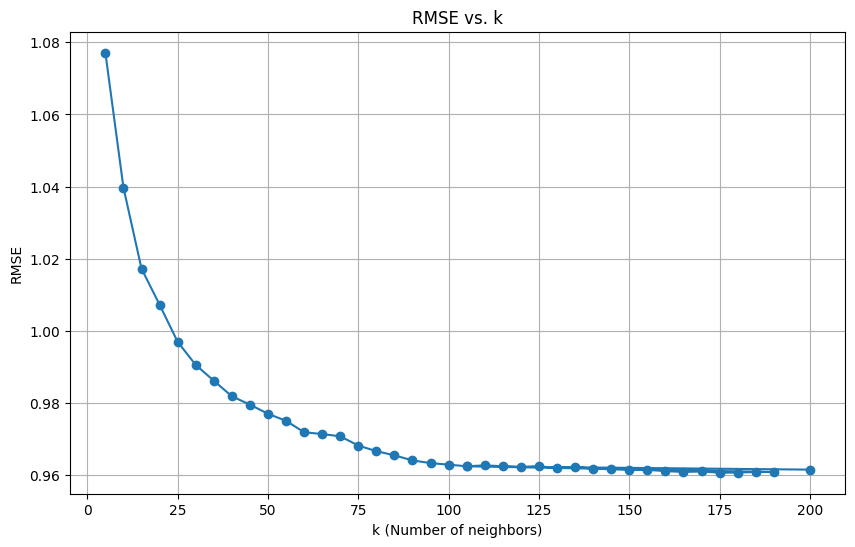

Optimal k: 175 with RMSE: 0.9607


In [27]:
optimal_k, optimal_rmse = find_optimal_k(k_values=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150,
                                                   155, 160, 165, 170, 175, 180, 185, 190, 105, 200])
print(f"Optimal k: {optimal_k} with RMSE: {optimal_rmse:.4f}")